## Introduction

As part of this blog post, we will be **reviewing** the [LaMini-LM: A Diverse Herd of Distilled Models from Large-Scale Instructions](https://arxiv.org/abs/2304.14402) (@laminilm) paper released on Apr 27, 2023.

The main objectives of this blog post are: 

1. *To provide a thorough review of **LaMini-LM** (@laminilm) reseasrch paper.*
2. *We will try to replicate most figures and share commentary on why some of the results might me misleading. Specifically we replicate @fig-5 in @sec-diversity.*
3. *Recreate a small sample of the 2.58M shared Instruction Dataset to showcase the complete process - see @sec-data-gen.*
4. *Compare similarity on generated instructions using sentence embeddings generated by using Sentence Transformer from HuggingFace.*
5. *Share all code in PyTorch that is used as part of this blog post.*
6. *Compare evaluation results from the paper with our own evaluation on multiple NLP datasets - see @sec-model-eval.*\
7. *We do our own human evaluation in @sec-human-eval. Honestly speaking, for the three results, the results for the 1.5B GPT-2 LaMini model, the results were unsatisfactory.* 😔

## Dataset Generation {#sec-data-gen}

### Introduction

The authors provide a large dataset of 2.58M instructions and responses. 

Two examples in the LaMini-instruction data:
```python
{
    "instruction": "What is the capital of Australia?\n\nIs Canberra the only city chosen to serve as a capital due to a compromise between Sydney and Melbourne?", 
    "response": "The capital of Australia is Canberra. Yes, Canberra was chosen as the capital of Australia in 1908 due to a compromise between Sydney and Melbourne, as neither city wanted the other to become the capital.",
    "instruction_source": "generated_flan"
}


{
    "instruction": "Create a poem that has the word \"ocean\" in every other line.", 
    "response": "The ocean's depth is a mystery,\nIts waves crashing with energy.\nSalt air fills the coastal scene,\nThe ocean's blue hues pure and clean.\n\nSeagulls cry out a melancholy song,\nThe ocean's rhythm steady and strong.\nSunsets paint the water gold,\nThe ocean's secrets forever untold.",
    "instruction_source": "self_instruct_without_topic"
}
```

The dataset is built on top of existing resources and also newer *"instructions"+"responses"*.

From the paper:

> *We collate instructions from various prior datasets such as self-instruct (@selfinstruct), P3 (@p3), FLAN (@flan) and Alpaca (@alpaca).*

The researchers have collated existing resources and also generated a new set "instructions+responses" using `gpt-3.5-turbo` (ChatGPT) using Self-Instruct approach (@selfinstruct). At the time of writing I believe this is the biggest Instruction dataset available. 


Below I provide an overview of the existing datasets that are part of the 2.58M LaMini-LM dataset: 

1. **Self-Instruct:** Instruction, input, and output samples from a language model. (@selfinstruct)
2. **P3:** P3 (Public Pool of Prompts) is a collection of prompted English datasets covering a diverse set of NLP tasks. Hosted at HuggingFace [here](https://huggingface.co/datasets/bigscience/P3).
3. **FLAN:** Instruction dataset on a wide variety of datasets (473 datasets, 146 task categories, and 1,836 total tasks) using various instruction templates. Refer to the [GitHub repo](https://github.com/google-research/FLAN/tree/main/flan/v2) for more details.
4. **Alpaca:** 52K instruction-following demonstrations generated in the style of self-instruct using `text-davinci-003`. (@alpaca)

The authors use two strategies to generate instructions on top of existing ones which they called: 

1. Example-guided
2. Topic-guided

Let's look at them in detail in the following sections.

### Example Guided {#sec-example-guided}

Example guided generation follows @selfinstruct & @alpaca.

Specifically, the authors include only few random examples, and some limited constraints as shown in the example prompt in @fig-1. 

Newer instructions are generated by providing these examples from existing datasets - Self-Instruct ($X_{SI}$), P3 ($X_{P3}$) & FLAN ($X_{FLAN}$). 

![An example of instruction generation prompt based on three random examples from self-instruct](../images/lamini-example-guided.png){#fig-1}

To generate your own instructions using ChatGPT, either paste the above prompt in ChatGPT, or we can use the openai API like so: 

In [2]:
import openai
openai.api_key = "sk_" #Your API key goes here 

N = 20
examples = [
    'What are some things you can do to de-stress?', 
    'How can individuals and organizations reduce unconscious bias?',
    'Write a program to compute the sum of integers from k to n.'
]

prompt=f"""
<example>{examples[0]}</example>
<example>{examples[1]}</example>
<example>{examples[2]}</example>

Generate {N} diverse examples that are similar to the provided examples.
You do not need to provide a response to the generated examples.
Each example must include an instruction.
Each generated instruction can be either an imperative sentence or a question.
Each example must start with the label "<example>" and end with the label "</example>".
"""

messages = [{"role": "user", "content": prompt}]
response = openai.ChatCompletion.create(
    model='gpt-3.5-turbo',
    messages=messages,
    temperature=0, # not specified in the paper 
)
response.choices[0].message["content"]

In the above code, you can see how we can easily replace the `examples` list with a function that looks like - `get_random_examples(n=3, subset='self-instruct')` and based on that get example instructions from the existing datasets. By using different subsets, we can generate different examples. 

The instructions that are generated by using examples from $X_{SI}$, $X_{P3}$ & $X_{FLAN}$ are referred to as $\hat{X}_{SI}$, $\hat{X}_{P3}$ & $\hat{X}_{FLAN}$. So, the below 20 generated instructions would be part of $\hat{X}_{SI}$ because the 3 examples are from $X_{SI}$.

Running the above returns an output that looks like: 

```
<example>What are some healthy breakfast options?</example>
<example>How can you improve your public speaking skills?</example>
<example>Write a recipe for a vegan lasagna.</example>
<example>What are some ways to save money on groceries?</example>
<example>How can you improve your time management skills?</example>
<example>Write a workout plan for beginners.</example>
<example>What are some tips for studying effectively?</example>
<example>How can you improve your writing skills?</example>
<example>Write a program to find the largest number in an array.</example>
<example>What are some ways to improve your memory?</example>
<example>How can you improve your interpersonal communication skills?</example>
<example>Write a step-by-step guide for making a paper airplane.</example>
<example>What are some ways to reduce your carbon footprint?</example>
<example>How can you improve your problem-solving skills?</example>
<example>Write a program to check if a number is prime.</example>
<example>What are some ways to improve your creativity?</example>
<example>How can you improve your leadership skills?</example>
<example>Write a guide for making homemade soap.</example>
<example>What are some healthy breakfast options?</example>
<example>What are some ways to improve your emotional intelligence?</example>
```

### Topic Guided {#sec-topic-guided}

The process and prompt for topic guided instruction generation is slightly different from example-guided instruction generation.

The overall process for topic-guided generation looks like: 
    
1. Find a list of common categories from Wikipidea (Total 3.5M)
2. Filter out topics based on two rules.
    1. The category must be less than three words. 
    1. The category must comprise more than 10 sub-categories and 50 pages.
3. Use the prompt in @fig-2 and provide random examples from the same dataset and 3 topics obtained after filtering.

![An example of instruction generation prompt based on three random examples from self-instruct and three random topics.](../images/lamini-topic-guided.png){#fig-2}

In [65]:
import openai
openai.api_key = "sk_" #Your API key goes here 

N = 20
examples = [
    'Try coming up with a creative way to stay motivated during a workout.', 
    'In your opinion, what are the qualities of an effective sports coach?',
    'Return the SSN number for the person: "Yann LeCun"'
]
topics = ['Machine Learning', 'Infantry', 'Design bureaus']

prompt=f"""
<example>{examples[0]}</example>
<example>{examples[1]}</example>
<example>{examples[2]}</example>

Generate {N} diverse examples that are similar to the provided examples with the topics {topics[0]}, {topics[1]}, {topics[2]}".
You do not need to provide a response to the generated examples. 
Each example must include an instruction. Each generated instruction can be either an imperative sentence or a question. 
Each example must start with the label "<example>" and end with the label "</example>"."."""

messages = [{"role": "user", "content": prompt}]
response = openai.ChatCompletion.create(
    model='gpt-3.5-turbo',
    messages=messages,
    temperature=0, # not specified in the paper 
)
print(response.choices[0].message["content"])

As before, we can easily replace the `examples` list with a function that looks like - `get_random_examples(n=3, subset='self-instruct')` & also replace `topics` with a function that looks like - `get_random_topics(n=3, subset='wiki-categories')`.

Running the above code returns an output that looks like: 

```
<example>What are some common machine learning algorithms and their applications?</example>
<example>Design a new weapon for the infantry that is both effective and lightweight.</example>
<example>Retrieve the contact information for a design bureau specializing in sustainable architecture.</example>
<example>How can machine learning be used to improve healthcare outcomes?</example>
<example>Create a workout plan for an infantry soldier to improve their endurance and strength.</example>
<example>What are some key considerations when designing a user interface for a mobile app?</example>
<example>Find a machine learning library that is compatible with Python.</example>
<example>Develop a training program for infantry soldiers to improve their marksmanship skills.</example>
<example>What are some ethical concerns surrounding the use of machine learning in decision-making?</example>
<example>Design a new vehicle for the infantry that can navigate difficult terrain.</example>
<example>Research and compare different design bureaus to find one that aligns with your project goals.</example>
<example>How can machine learning be used to improve customer service in the retail industry?</example>
<example>Create a nutrition plan for an infantry soldier to optimize their performance in the field.</example>
<example>What are some best practices for designing a logo for a new brand?</example>
<example>Implement a machine learning algorithm to predict customer churn for a telecommunications company.</example>
<example>Develop a training program for infantry soldiers to improve their communication and teamwork skills.</example>
<example>What are some challenges that arise when designing for virtual reality?</example>
<example>Find a design bureau that specializes in creating interactive exhibits for museums.</example>
<example>How can machine learning be used to improve fraud detection in the financial industry?</example>
<example>Design a new piece of equipment for the infantry that can be used in urban environments.</example>
```

Some key things to note just from the small sample above, instructions like 

- *"Design a new piece of equipment for the infantry that can be used in urban environments"*
- *"Research and compare different design bureaus to find one that aligns with your project goals"*
- *"Retrieve the contact information for a design bureau specializing in sustainable architecture."*

are noisy. **As also mentioned in the paper, ChatGPT has failed to provide enough context for the instructions.**
 
- *"Design a new piece of equipment for the infantry that can be used in urban environments"*

The above instruction IMHO is very generic.

- *"Research and compare different design bureaus to find one that aligns with your project goals"*

The model has failed to define project goals or say anything about the "project"

- *"Retrieve the contact information for a design bureau specializing in sustainable architecture."*

The model is asking to generate contact information, and it's the response as we will see in the next section that's more vague, not just the instruction.

### Response Generation

Let's collate the above instructions and generate responses for each one to create the resulting pairs. One could simply copy paste the instructions in ChatGPT or use the openAI API as before. 

Let's take five instructions as examples to generate a `.jsonl` type `dataset` as below which can then be used to finetune models using the openAI API.

In [70]:
import openai
from collections import defaultdict

openai.api_key = "sk_" #Your API key goes here 

dataset = defaultdict(dict)

instructions = [
    "<example>What are some common machine learning algorithms and their applications?</example>",
    "<example>Design a new weapon for the infantry that is both effective and lightweight.</example>",
    "<example>Retrieve the contact information for a design bureau specializing in sustainable architecture.</example>",
    "<example>How can machine learning be used to improve healthcare outcomes?</example>",
    "<example>Create a workout plan for an infantry soldier to improve their endurance and strength.</example>",
]

for idx, inst in enumerate(instructions):    
    prompt = f"""Given the following instruction separated by `<example>`, generate a response.
    Response must start with the label "<response>" and end with the label "</response>".
    
    Instruction: {inst}    
    """
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model='gpt-3.5-turbo',
        messages=messages,
        temperature=0, # not specified in the paper 
    )
    dataset[idx] = {'prompt': inst, 'completion':response.choices[0].message["content"]}

Running above code will give us a dataset that can be used to finetune the base models using OpenAI. This dataset looks something like:

```python
defaultdict(dict,
            {0: {'prompt': '<example>What are some common machine learning algorithms and their applications?</example>',
              'completion': '<response>Some common machine learning algorithms and their applications include: \n- Linear Regression: used for predicting numerical values\n- Logistic Regression: used for classification problems\n- Decision Trees: used for both classification and regression problems\n- Random Forest: used for classification, regression, and feature selection\n- Support Vector Machines: used for classification and regression problems\n- K-Nearest Neighbors: used for classification and regression problems\n- Neural Networks: used for complex problems such as image recognition and natural language processing</response>'},
             1: {'prompt': '<example>Design a new weapon for the infantry that is both effective and lightweight.</example>',
              'completion': '<response>A possible solution for a new weapon for the infantry that is both effective and lightweight could be a compact assault rifle that uses advanced materials and technology to reduce weight without sacrificing firepower. The rifle could have a modular design that allows for easy customization and upgrades, and could also incorporate features such as a suppressor and a holographic sight for improved accuracy. Additionally, the rifle could be designed to be easily disassembled and reassembled for maintenance and cleaning in the field.</response>'},
             2: {'prompt': '<example>Retrieve the contact information for a design bureau specializing in sustainable architecture.</example>',
              'completion': '<response>Here is the contact information for a design bureau specializing in sustainable architecture:</response>'},
             3: {'prompt': '<example>How can machine learning be used to improve healthcare outcomes?</example>',
              'completion': '<response>Machine learning can be used to improve healthcare outcomes by analyzing large amounts of patient data to identify patterns and predict potential health issues. This can lead to earlier diagnosis and treatment, as well as personalized treatment plans based on individual patient characteristics. Additionally, machine learning can help healthcare providers identify patients who are at risk for readmission or complications, allowing for targeted interventions to improve outcomes and reduce costs.</response>'},
             4: {'prompt': '<example>Create a workout plan for an infantry soldier to improve their endurance and strength.</example>',
              'completion': '<response>Here is a workout plan for an infantry soldier to improve their endurance and strength:</response>\n- Warm up: 5-10 minutes of light cardio (jogging, jumping jacks, etc.)\n- Circuit 1: 3 rounds of the following exercises with minimal rest in between:\n  - 20 push-ups\n  - 20 squats\n  - 20 lunges (10 per leg)\n  - 1-minute plank\n- Circuit 2: 3 rounds of the following exercises with minimal rest in between:\n  - 20 burpees\n  - 20 jumping jacks\n  - 20 mountain climbers (10 per leg)\n  - 1-minute wall sit\n- Circuit 3: 3 rounds of the following exercises with minimal rest in between:\n  - 20 dumbbell rows (10 per arm)\n  - 20 dumbbell curls (10 per arm)\n  - 20 dumbbell overhead presses (10 per arm)\n  - 1-minute rest\n- Cool down: 5-10 minutes of stretching and foam rolling.'}})
```

From the smallest of examples, it appears as though: 

```python 
{
    'prompt': '<example>Retrieve the contact information for a design bureau specializing in sustainable architecture.</example>',
    'completion': '<response>Here is the contact information for a design bureau specializing in sustainable architecture:</response>'
}
```

is not of high quality. **This small exercise indicates that there might be more noise in the 2.58M "instruction+response" dataset shared by the authors of LaMini-LM.**

## Dataset Exploration {#sec-data-exploration}

In the last section I shared how the dataset generation looks like for `LaMini-LM`. In this section we will explore the 2.58M instruction dataset. The dataset has been shared publicly and is available on HuggingFace [here](https://huggingface.co/datasets/MBZUAI/LaMini-instruction/viewer/mbzuai-distil--instruction/train).

![Dataset Preview on Huggingface.](../images/lamini-hf-dataset.png){#fig-3}

### Statistics

Some statistics about the dataset from the research paper have been shared in @fig-4 below.

![Data statistics of the generated dataset.](../images/lamini-dataset-stats.png){#fig-4}

As can be seen aboce, in total there are 2.58M samples in `LaMini-LM`. It can be observed that the instructions for $D_{P3}$ & $D_{FLAN}$ are in general longer compared to the rest. 

### Diversity {#sec-diversity}

As part of this section we will be looking at the diversity in the generated instructions. We will also try to recreate @fig-5 ourselves using [sentence-transformers](https://www.sbert.net/).

The authors took a sample of 50K instructions from ${\hat{X}_{SI}}$, ${\hat{X}_{A}}$, ${\hat{X}_{P3}}$ & $X_{P3}$ and visualised t-SNE of instruction sentence embeddings that were computed using Sentence Transformer.

The t-SNE figure has been shared below. 

![The t-SNE visualizations of 50k sample of instruction sentence embeddings.](../images/lamini-tsne.png){#fig-5}

Some comments about the the t-SNE visualisation directly from the paper: 

- *We observe that $\hat{X}_{SI}$ exhibits greater diversity than $\hat{X}_A$ and $\hat{X}_{P3}$ is slightly more diverse than $X_{P3}$.*

But in no way does having a wider spread in $\hat{X}_{SI}$ and  $\hat{X}_{P3}$ signify that the instructions are of higher quality. What if the instructions are meaningless? 

For example one of the instructions from the small 20 instructions that were generated in @sec-topic-guided is:

> Retrieve the contact information for a design bureau specializing in sustainable architecture.

And it's not just the instruction, but rather the response too: 

```python
{
    'prompt': '<example>Retrieve the contact information for a design bureau specializing in sustainable architecture.</example>',
    'completion': '<response>Here is the contact information for a design bureau specializing in sustainable architecture:</response>'
}
```

I think by training on such examples that might not be of high quality, we are allowing the model to hallucinate. 

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from umap import UMAP
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer
from datasets import load_dataset, load_dataset_builder

In [3]:
ds_builder = load_dataset_builder("MBZUAI/LaMini-instruction")
ds_builder.info.features

{'instruction': Value(dtype='string', id=None),
 'response': Value(dtype='string', id=None),
 'instruction_source': Value(dtype='string', id=None)}

In [4]:
dataset = load_dataset("MBZUAI/LaMini-instruction")
dataset

Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/MBZUAI___parquet/default-3bf051cc03b2354d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'response', 'instruction_source'],
        num_rows: 2585615
    })
})

Total of **2582019** samples in the dataset ➡️ 2.58M. Also, we have a column `instruction_source` that matches `Dataset` in @fig-4. First, we filter out the datasets based on source. We are trying to replicate @fig-5.

In [5]:
X_alpaca = dataset.filter(lambda example: example["instruction_source"]=='alpaca')
X_p3     = dataset.filter(lambda example: example["instruction_source"]=='original_p3')
X_hat_si = dataset.filter(lambda example: example["instruction_source"] in ['self_instruct_with_topic', 'self_instruct_without_topic'])
X_hat_p3 = dataset.filter(lambda example: example["instruction_source"]=='generated_p3')
X_alpaca['train'].num_rows, X_p3['train'].num_rows, X_hat_si['train'].num_rows, X_hat_p3['train'].num_rows

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/MBZUAI___parquet/default-3bf051cc03b2354d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-9195cf0efbc66452.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/MBZUAI___parquet/default-3bf051cc03b2354d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-4d4436fd5c79b44c.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/MBZUAI___parquet/default-3bf051cc03b2354d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-990830c59dd517ae.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/MBZUAI___parquet/default-3bf051cc03b2354d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-b3523be466a9a289.arrow


(51985, 464396, 550137, 297312)

Next, let's keep the 50K sample from each source as per the research paper. 

In [6]:
sample_dict = {}
for X in tqdm([X_hat_si, X_hat_p3, X_alpaca, X_p3]):
    np.random.seed(123)
    idxs = np.random.choice(X['train'].num_rows, 50000)
    sample_50k = X['train'][idxs]
    src = np.unique(sample_50k['instruction_source'])[0]
    if str(src).startswith('self_instruct'): src = 'generated_self_instruct'
    sample_dict[src] = sample_50k['instruction']
df = pd.DataFrame(sample_dict)
df.head(2)

  0%|          | 0/4 [00:00<?, ?it/s]

,generated_self_instruct,generated_p3,alpaca,original_p3
0,How does tobacco use affect the cardiovascular...,What do you read in your free time?\nRead a be...,Classify the types of data structures.,"I know that the answer to the question ""What h..."
1,Watch a sitcom and write down three humorous s...,Suppose a survey found that the majority of pa...,Determine how this example sentence illustrate...,The toddler became cranky. \n\nI am hesitating...


Now that we have the 50K sample, we could just use `sentence-transformer` to create the embeddings. I have already done that using a GPU. 

In [7]:
# Convert to Sentence embeddings and then apply `UMAP` to get 2D projections
if not os.path.exists('../assets/projections_alpaca.npy'):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    for col in tqdm(df.columns):
        sentence_embeddings = model.encode(df[col], batch_size=256, show_progress_bar=True, device='cuda')
        umap_2d = UMAP(random_state=0)
        umap_2d.fit(sentence_embeddings)
        projections = umap_2d.transform(sentence_embeddings)
        np.save(f'../assets/projections_{col}.npy', projections)

Let's load the UMAP projections and store in a new DataFrame called `df_proj`.

In [8]:
df_proj = pd.DataFrame()
for col in df.columns:
    projections = np.load(f'../assets/projections_{col}.npy')
    _df = pd.DataFrame(projections, columns=[f'{col}_0', f'{col}_1'])
    _df[col] = df[col]
    df_proj = pd.concat([df_proj, _df], axis=1)

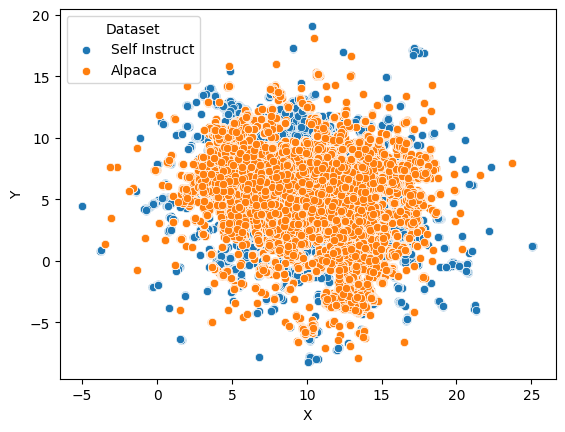

In [9]:
ax = sns.scatterplot(data=df_proj, x='generated_self_instruct_0', y='generated_self_instruct_1')
sns.scatterplot(data=df_proj, x='alpaca_0', y='alpaca_1')
ax.set(xlabel='X', ylabel='Y');
plt.legend(title='Dataset', loc='upper left', labels=['Self Instruct', 'Alpaca']);

### Human Evaluation

From the paper: 

*We follow the human evaluation protocol given by Wang et al. (2022a), which categorizes the quality of the generated text into four levels:*

- *Rate-A: The generated text is of high quality;*
- *Rate-B: The generated text is acceptable but has minor errors;* 
- *Rate-C: The generated text has significant errors in content.*
- *Rate-D: The generated text is completely unacceptable.*

*We randomly sample 20 examples from each subset of $D_{ALL}$ and one of the co-authors scores the generated text.*

*In general, both the generated instructions and the generated responses are of high quality as shown in @fig-6.*

![Human evaluation results for the generated instruction dataset.](../images/lamini-human-evaluation.png){#fig-6 width=60%}

As part of this blog post, let's look at `self_instruct_with_topic` and perform human evaluation on 20 samples ourselves.

In [11]:
dataset_si_with_topic = dataset.filter(lambda example: example["instruction_source"] == 'self_instruct_with_topic')
dataset_si_with_topic = dataset_si_with_topic.shuffle(seed=42)
sample_20 = dataset_si_with_topic['train'][range(20)]

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/MBZUAI___parquet/default-3bf051cc03b2354d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-d9007dd1dde13ff9.arrow
Loading cached shuffled indices for dataset at /home/ubuntu/.cache/huggingface/datasets/MBZUAI___parquet/default-3bf051cc03b2354d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-d54e2b73deab01dc.arrow


Now let's score the 20 samples for `self_instruct_with_topic`, below, I used a simple IpyWidget that I created using ChatGPT. :) 

In [14]:
import ipywidgets as widgets
from IPython.display import display

# Create widgets to display the current example
instruction_widget = widgets.HTML(layout=widgets.Layout(width='50%'))
response_widget = widgets.HTML(layout=widgets.Layout(width='25%'))
score_widget = widgets.Dropdown(options=[('', 0), ('1', 1), ('2', 2), ('3', 3), ('4', 4)], layout=widgets.Layout(width='25%'))

# Create a container for the example
example_container = widgets.HBox([instruction_widget, response_widget, score_widget])

# Create buttons for navigation
previous_button = widgets.Button(description='Previous')
next_button = widgets.Button(description='Next')
submit_button = widgets.Button(description='Submit')
clear_button = widgets.Button(description='Clear')

# Keep track of the current example index
current_index = 0

# Initialize a list to store the scores
scores = [0] * len(sample_20['instruction'])

def update_example(index):
    instruction_widget.value = sample_20['instruction'][index]
    response_widget.value = sample_20['response'][index]
    score_widget.value = scores[index]

def on_previous(button):
    global current_index
    scores[current_index] = score_widget.value
    current_index = max(0, current_index - 1)
    update_example(current_index)

def on_next(button):
    global current_index
    scores[current_index] = score_widget.value
    current_index = min(len(sample_20['instruction']) - 1, current_index + 1)
    update_example(current_index)

def on_submit(button):
    scores[current_index] = score_widget.value
    print('Scores:', scores)

def on_clear(button):
    scores[current_index] = 0
    score_widget.value = 0

# Set button callbacks
previous_button.on_click(on_previous)
next_button.on_click(on_next)
submit_button.on_click(on_submit)
clear_button.on_click(on_clear)

# Display the example container and navigation buttons
display(example_container)
display(widgets.HBox([previous_button, next_button]))
display(widgets.HBox([submit_button, clear_button]))

# Initialize the first example
update_example(current_index)

![IpyWidget for scoring instructions & responses](../images/lamini-widget.png){#fig-7}

You can see how hard it is to score even 20 samples each. Scoring is an intensive task especially when it is about topics that the labeler has no idea about. Above, the instruction is *"What are some behavioral patterns exhibited by Zygaenoidea moths?"*.

As a labeler, I have no idea what *"Zygaenoidea moths"* are, let alone know their characterstics. I had to search for *"Zygaenoidea moths"* on google, and that linked me to scholarly articles. 

Through this simple exercise, I hope I have showcased how difficult it can be to rate responses generated by the LLM. 

## Dataset Review {#sec-dataset-review}

As part of @sec-data-gen and @sec-data-exploration, by calling the OpenaiAPI ourselves, we saw that there might be noise in the dataset. 

`gpt-3.5-turbo` fails to provide context in some of the instructions that we saw before like: 

- *"Research and compare different design bureaus to find one that aligns with your project goals”*
- *“Retrieve the contact information for a design bureau specializing in sustainable architecture.”*

This means that there is possibility there is noise in the dataset. It is harder to look at text and figure out noise and clean datasets, IMHO, this is an open research question and I will try to work on this in my next blog post. 

Also, from the simple exercise, we saw how hard it can be to label Instruction and Response. There is no direct way, if the labeler doesn't have knowledge about the topic, then the task becomes even more intensive. 

## Model Training

From the paper: 

*We present **LaMini-LM**, a family of language models instruction-tuned on our 2.58M instructions dataset $D_{ALL}$. We train two types of models, encoder-decoder and decoder-only, for architectural comparison. The size for both categories of models ranges from 61M to 1.5B to facilitate size comparison. The underlying models for initialization are from five sources, including T5 (Raffel et al., 2020), Flan-T5 (@flant5), Cereberas-GPT (@cerebrasgpt), GPT-2 (Radford et al., 2019), and GPT-Neo (@pile).*

![LaMini-LM collection.](../images/lamini-eval.png){#fig-8 width=60%}

Also, from the paper: 

*We finetune all models over 5 epochs and a batch size of 1024. For our encoder-decoder models, we use a learning rate of 5 × 10−4 following Chung et al. (2022). For our decoder-only models, we follow the same configuration as Alpaca (Taori et al., 2023) including the learning rate of 2 × 10−5. We use HuggingFace’s transformers for training. Moreover, we use the same prompt wrapper as Alpaca (Taori et al., 2023), hence we also wrap our instruction similarly during inference. We perform all of our experiments on 8×V100 (32G) and 8×A100 (40G) GPUs.*

As part of this blog post, we will not be re-training the models, but you can see it is supervised finetuning on the Instruction Dataset using `Transformers` library.

## Model Evaluation {#sec-model-eval}

The authors have evaluated the performance of their trained models on several NLP tasks using model evaluation harness. (@eval-harness)

As part of this blog post we will also be evluating the models using this framework.

Results of model evaluation provided by the authors are shared in the table below. I have also shared the results from LLAMA.

![LaMini-LM collection.](../images/lamini-eval-table.png){#fig-9 width=80%}

As shared by [anton](https://twitter.com/abacaj), and as shown above, the results from `LaMini-LM`, don't match `LLAMA`.

The results shared in the original LLAMA paper are better compared to those shared in the LaMini-LM research paper. The most surprising is OpenBookQA, where in the LLAMA paper the reported accuracy is 57.2% compared to 42.4% in LaMini-LM.

To further analyse, let's run evaluation on BoolQ, the results are reported in LLAMA, but not present in LaMini-LM. 

To do this, let's first install the library:

```python
git clone https://github.com/EleutherAI/lm-evaluation-harness
cd lm-evaluation-harness
pip install -e .
```

Next, we could just simply run 

```python
python main.py --model hf-causal --model_args pretrained=MBZUAI/LaMini-GPT-1.5B --tasks openbookqa,boolq,piqa --device cuda:0
```

to evaluate the 1.5 GPT-2 on OpenBookQA (@openbookqa), BoolQ (@boolq), PIQA (@piqa). 

|   Task   |Version| Metric |Value |   |Stderr|
|----------|------:|--------|-----:|---|-----:|
|boolq     |      1|acc     |0.7725|±  |0.0073|
|piqa      |      0|acc     |0.7127|±  |0.0106|
|          |       |acc_norm|0.7214|±  |0.0105|
|openbookqa|      0|acc     |0.2680|±  |0.0198|
|          |       |acc_norm|0.3440|±  |0.0213|

: Evaluation Results on `BoolQ`, `PIQA`, `OpenBookQA` {#tbl-eval-results}

Interesting results to say the least, on `BoolQ`, it appears as though the results for `LaMini-GPT` are better than `LLAMA`. LLAMA's 7B model is at 76.5% accuracy whereas `LaMini-GPT` is at 77.25% accuracy. 

Also, our results on OpenBookQA don't match those provided in the paper. The accuracy we get is only 26.8% compared to the reported 39.8% in the paper. 

> At this point, as a reader, I am not sure if I trust the results from the LaMini-LM paper. I've just followed the instructions and results on OpenBookQA are different?

I have asked the authors to check if there is something that they have done differently compared to my understanding. 

Based on the above table, let's re-run for other evaluation datasets too and see if our results match those from the paper.

```python
python main.py --model hf-causal --model_args pretrained=MBZUAI/LaMini-GPT-1.5B --tasks openbookqa,sciq,race,record,sst,mrpc,rte,wsc,winogrande --device cuda:0
```

### Human Evaluation {#sec-human-eval}

Lastly, let's look at the human evaluation bit. From the paper: 

*To complete the evaluation, we additionally evaluate the practicality of both our LaMini-LM and our baseline models by utilizing the user-oriented instructions from Wang et al. (2022a), which consists of 252 instructions covering 71 commonly used apps use-cases.*


Also, would have been nice to know what these 252 Instructions look like. The authors have kindly provided the human evaluation results table which I share below in @fig-10, but not the evaluation instructions. 

![LaMini-LM collection.](../images/lamini-human-eval.png){#fig-10 width=80%}

In [3]:
# pip install -q transformers
from transformers import pipeline
checkpoint = "MBZUAI/LaMini-GPT-1.5B" 
model = pipeline('text-generation', model = checkpoint, device='cuda:0')

instruction = 'Two large and 1 small pumps can fill a swimming pool in 4 hours. One large and 3 small pumps can also fill the same swimming pool in 4 hours. How many hours will it take 4 large and 4 small pumps to fill the swimming pool?'
input_prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:"
generated_text = model(input_prompt, max_length=512, do_sample=True)[0]['generated_text']
print("Response", generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Response Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Two large and 1 small pumps can fill a swimming pool in 4 hours. One large and 3 small pumps can also fill the same swimming pool in 4 hours. How many hours will it take 4 large and 4 small pumps to fill the swimming pool?

### Response:It will take 4 large and 4 small pumps (6 pumps total) 4 hours to fill the swimming pool.


> By the way, ChatGPT nails it and returns the right answer "1 hour & 36 minutes" but it would be unfair to compare a 1.5B model with ChatGPT.

In [6]:
instruction = 'Today is 30 Apr, 2023. I want to participate in a marathon on July 30, 2023. Please create a training program for me. I can run 5kms easily as of now.'
input_prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:"
generated_text = model(input_prompt, max_length=512, do_sample=True)[0]['generated_text']
print("Response", generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Response Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Today is 30 Apr, 2023. I want to participate in a marathon on July 30, 2023. Please create a training program for me. I can run 5kms easily as of now.

### Response:Understood. Training program created for participant. Training will be divided into four phases: 
1. Endurance training
2. Strength and flexibility training 
3. Low-impact exercise (stretching, yoga, etc.) 
4. Functional training (running drills, pace training, etc.)


This is not a statisfactory and I would rate it `Rate-C`, "The response is relevant and responds to the instruction, but it has significant errors in the content." 

In [8]:
instruction = 'Write a product description for a sustainable, eco-friendly backpack made from recycled materials.'
input_prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:"
generated_text = model(input_prompt, max_length=512, do_sample=True)[0]['generated_text']
print("Response", generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Response Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Write a product description for a sustainable, eco-friendly backpack made from recycled materials.

### Response:Sustainable, eco-friendly backpack made from recycled materials.


The result above looks unsatisfactory too. 

## Conclusion

To summarise, 

1. We recreated a small sample of the dataset using example-guided and topic-guided approach as mentioned in the paper. 
2. We used OpenaiAPI to also generate responses for the paper. 
3. We replicated @fig-5 which showcases that diversity in Self-Instruct guided $\hat{X}_{SI}$ is actually more compared to Alpaca $\hat{X}_A$
4. The authors were very kind enought to update the HF dataset and add a new column called `instruction_source` to match @fig-4.
5. We used `ChatGPT` to create a simple IpyWidget to rate the scores. Through this simple exercise we realised how hard it can be to score text based responses. 
6. We ran our own model evaluation on `BoolQ`, `PIQA`, `OpenBookQA`, `SciQ`, `RACE`, `Record`, `SST` and more reasoning based datasets. We found that our results don't match the ones provided in the paper in @fig-9.
7. We also saw that the results provided for LLAMA don't match those from the original paper. 